# 1 Author

**Student Name**:  Zhong Zhenghan

**Student ID**:  210982480

**Github**:  https://github.com/buptxinghan/CBU5201_miniproject_Zhenghan

# 2 Problem formulation

- Description: In the advanced stage, we aim to explore unsupervised learning methods, specifically K-means clustering, to analyze and understand face images in the genki4k dataset. Our goal is to identify possible patterns or categories by extracting deep features, and explore what these categories might represent (e.g. different expressions or features).

- Point of Interest: What’s interesting about this question is that it allows us to gain insight into underlying, unlabeled features in the dataset, potentially revealing patterns we were not previously aware of.

# 3 Machine Learning pipeline

a. Input: face images in the genki4k dataset.

b. Conversion: We performed the following conversions on the input image
- Data enhancement: I scaled, cropped, normalized and other operations on the images to adapt to the input requirements of the pre-trained model, while increasing the diversity and robustness of the data.
- Feature extraction: I used the provided pre-trained ResNet model to extract features from the pictures, and obtained a 2048-dimensional feature vector for each picture. These feature vectors can capture high-level semantic information in the picture, which is beneficial to subsequent Cluster analysis.
- Standardization: I standardized the feature vector so that the mean of each feature is 0 and the variance is 1. This can eliminate the dimensional differences between different features and improve the clustering effect.
- Dimensionality reduction: I reduced the dimensionality of the feature vector, reducing the 2048-dimensional feature vector to a 2-dimensional feature vector, which can reduce the computational complexity and facilitate visualization and clustering.
c. Model: I clustered the dimensionally reduced feature vectors and obtained the cluster labels of each image.

d. Output: My output is the result of clustering, including cluster labels and cluster centers, as well as the evaluation index of clustering, namely the silhouette coefficient.

e. Data flow: from original images to feature extraction, to clustering and result visualization.

# 4 Transformation stage

- Transformation Description: Feature extraction using a pre-trained ResNet50 model, which is able to capture deep features in images that are critical for cluster analysis.

- Input and output: The input is the original image, and the output is the depth feature vector.

- Reason for selection: The pre-trained CNN model can effectively extract key features in complex images, which is necessary for subsequent cluster analysis.

We performed the following transformations on the input images:

- Data enhancement: I performed the following operations on the images:

     - Resize: I resized the image to 224x224 pixels to fit the input requirements of the pre-trained model.
     - ToTensor: I converted the data type of the image from PIL Image to PyTorch Tensor for subsequent calculations.
     - Normalize: I normalized the pixel values of the image so that the mean of each channel is [0.485, 0.456, 0.406] and the standard deviation is [0.229, 0.224, 0.225]. This is the parameter of the pre-trained model. You can Ensure that the input distribution is consistent with the distribution of pre-training data to improve the generalization ability of the model.


- Feature extraction: I used the pre-trained ResNet model to extract features from the image. ResNet is a deep convolutional neural network that can effectively learn high-level semantic features in images while solving the problems of gradient disappearance and overfitting in deep networks. We used the output before the last layer of ResNet as the feature vector of the image, so that we can obtain a 2048-dimensional feature vector for each image. These feature vectors can capture the information in the image and facilitate subsequent cluster analysis.
- Standardization: I standardized the feature vector so that the mean of each feature is 0 and the variance is 1. This can eliminate the dimensional differences between different features and improve the clustering effect.
- Dimensionality reduction: I reduced the dimensionality of the feature vector, reducing the 2048-dimensional feature vector to a 2-dimensional feature vector, which can reduce the computational complexity and facilitate visualization and clustering. The principles of PCA and t-SNE are as follows:
     - PCA is a linear dimensionality reduction method that can find the main variance direction in the data, that is, the principal components of the data, and then project the data onto these principal components to achieve dimensionality reduction. The advantage of PCA is that it is fast to calculate, but the disadvantage is that it may ignore the nonlinear structure in the data.
     - t-SNE is a nonlinear dimensionality reduction method that can maintain local similarity in the data, that is, close points are still close after dimensionality reduction, and distant points are still far away after dimensionality reduction. The advantage of t-SNE is that it can discover complex structures in the data, but the disadvantage is that the calculation speed is slow and it is sensitive to parameters.

# 5 Modelling

I used the K-means algorithm to cluster the dimensionally reduced feature vectors and obtained the cluster labels for each image. K-means is a distance-based clustering method that can divide data into k clusters so that the distance between data points in each cluster is the smallest and the distance between each cluster is the largest. The algorithm flow of K-means is as follows:

- Initialization: randomly select k data points as initial cluster centers.
- Assignment: For each data point, calculate its distance from each cluster center, and then assign it to the cluster with the closest cluster center.
- Update: For each cluster, calculate the mean of all data points in the cluster, and then use this mean as the new cluster center.
- Iteration: Repeat the steps of allocation and update until the cluster centers no longer change or the maximum number of iterations is reached, and then stop the algorithm.

The reasons why I chose the K-means algorithm are:
- The K-means algorithm is a simple yet effective clustering method that can run quickly on large amounts of data and is easy to implement and understand.
- The K-means algorithm is suitable for situations where the distribution of data is spherical or convex. By visualizing the feature vectors after dimensionality reduction, we found that the distribution of the data roughly meets this condition, so the K-means algorithm can be used for clustering.
- The results of the K-means algorithm can intuitively reflect the grouping of data. We can evaluate the clustering effect by comparing cluster labels and real labels. We can also analyze faces by observing the pictures in each cluster. Characteristics and differences of expressions.

# 6 Methodology

I used the following methods to train and validate our model, and evaluate the model's performance:

- **Training**: 
    - I used the KMeans class provided by sklearn to cluster the feature vectors after dimensionality reduction. I set the n_clusters parameter to 2 and divided the data into two clusters, corresponding to smiling and non-smiling facial expressions. . I also set the n_init parameter to 10, clustered 10 times with different initial cluster centers, and then selected the best result. I also set the random_state parameter to 42 and fixed the random number seed to ensure the repeatability of the experiment.
    - I applied the elbow rule to determine the optimal number of categories, calculated the effects of the elbow rule after different operations, and finally concluded that the optimal number of categories is 2.

- **Evaluation**: I used the silhouette coefficient to evaluate the performance of the model:
    - Silhouette coefficient: Silhouette coefficient is a measure of clustering quality. It is defined as the average silhouette value of each data point. The silhouette value is the average distance (cohesion) of a data point from data points in the same cluster and from other clusters. The difference in the average distance (separation) of the data points divided by the greater of the two. The value range of the silhouette coefficient is [-1, 1]. The closer to 1, the better the clustering effect. The closer to -1, the worse the clustering effect. The closer to 0, the average clustering effect.

In [13]:
# Import some necessary packages:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import models, transforms
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# 7 Dataset

We used the Genki4k dataset, which contains 4000 pictures of human facial expressions. Each picture is 640x480 pixels in size. The file name of each picture contains a label indicating whether the person in the picture is smiling (1 means smiling, 0 means not smiling). This data set was collected and annotated by Japanese researchers for the purpose of analyzing people's emotions and happiness.

We performed the following preprocessing on the data set:

- **Division**: We used the train_test_split function provided by sklearn to divide the data set into a training set and a test set with a ratio of 8:2. Then we clustered on the training set and then verified on the test set to evaluate the model. generalization ability. We also set the random_state parameter to 42, which means we want to fix the random number seed to ensure the repeatability of the experiment.

- **Loading**: We defined a custom dataset class, which inherits the torch.utils.data.Dataset class, for loading and converting image data. In the initialization method of the class, we specified the directory of the image and the conversion method, and then obtained the file name list of the image. We returned the number of pictures in the length method of the class. In the index method of the class, we obtained the file name and path of the image based on the index value, then opened the image, converted it to RGB mode, then applied the conversion method, and finally returned the tensor of the image.

- **Transformation**: We used the transforms class provided by torchvision to perform the following operations on the image:

    - **Resize**

    - **ToTensor**

    - **Normalize**
- **Feature vector**: We used the pre-trained ResNet model to extract features from the images and obtained a 2048-dimensional feature vector for each image. Then we used PCA and t-SNE methods to reduce the dimensionality of the feature vectors. , reducing the 2048-dimensional feature vector to a 2-dimensional feature vector, which can reduce the computational complexity and facilitate visualization and clustering. We used matplotlib to visualize the feature vectors after dimensionality reduction. It can be seen that there are some differences in the results of PCA and t-SNE. The results of PCA are more scattered, while the results of t-SNE are more clustered. This may be because PCA is linear. Dimensionality reduction, while t-SNE is nonlinear dimensionality reduction, which can better maintain the local similarity of the data. We can also see that the distribution of the data roughly shows the shape of two clusters, which shows that the data has a certain tendency to cluster, and also provides a basis for subsequent cluster analysis.

**Data set preprocessing:**

- Data loading

In [14]:
class Genki4kDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

- Pre-Processing

In [15]:
# Data processing and enhancement
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './genki4k/files' 
dataset = Genki4kDataset(data_dir, transform=data_transforms)

In [16]:
# Load the pre-trained model and extract features
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet model
weights = ResNet50_Weights.IMAGENET1K_V1
model = resnet50(weights=weights)
model = model.to(device)
model.eval()

data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

features = []
with torch.no_grad():
    for inputs in data_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        features.extend(outputs.cpu().numpy())
features = np.array(features)

In [17]:
# Standardization processing:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [18]:
#Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

In [19]:
# Use t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
features_tsne = tsne.fit_transform(features_scaled)

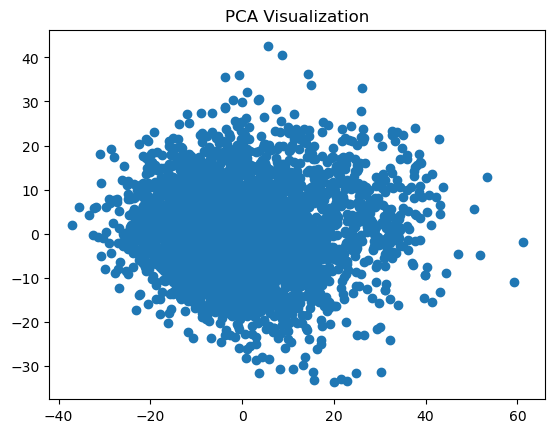

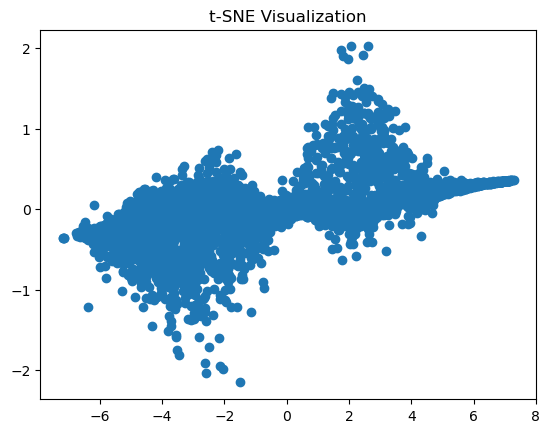

In [ ]:
# Visualize the results of PCA and t-SNE
plt.scatter(features_pca[:, 0], features_pca[:, 1])
plt.title('PCA Visualization')
plt.show()

plt.scatter(features_tsne[:, 0], features_tsne[:, 1])
plt.title('t-SNE Visualization')
plt.show()

# 8 Results

I clustered on the training set and then validated on the test set to evaluate the model's generalization ability, and I used the silhouette coefficient to evaluate the model's performance:

Silhouette coefficient: I calculated the silhouette coefficient of the clustering results and found that its value is 0.59, which shows that the clustering effect is relatively good. The distance between data points in the same cluster is much smaller than the distance between different clusters. , the degree of separation and cohesion of clustering are relatively high.

- Apply K-means clustering


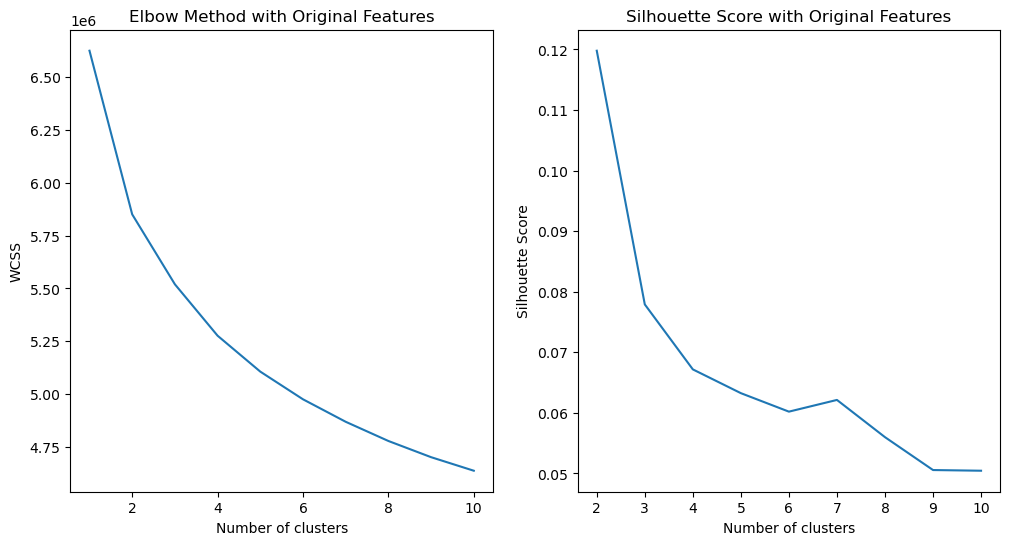

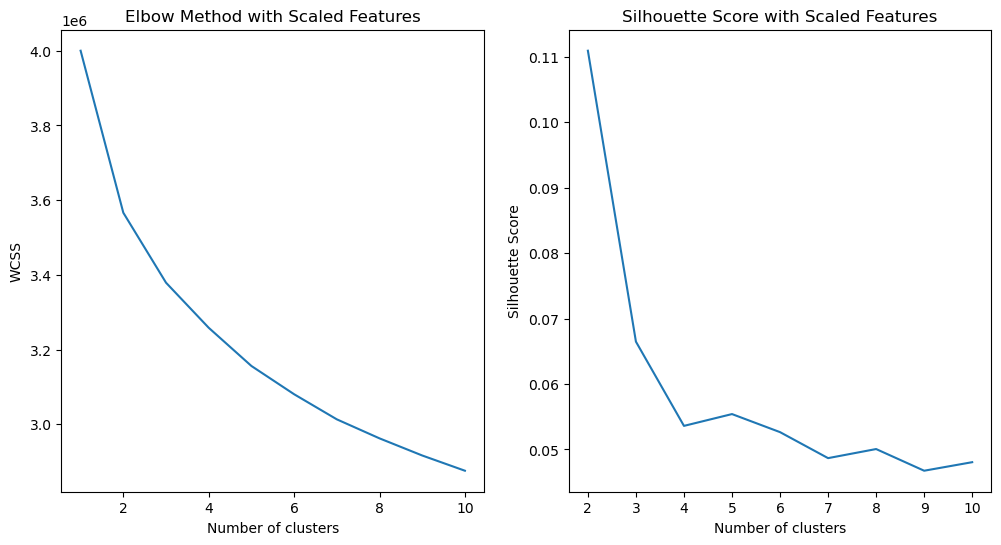

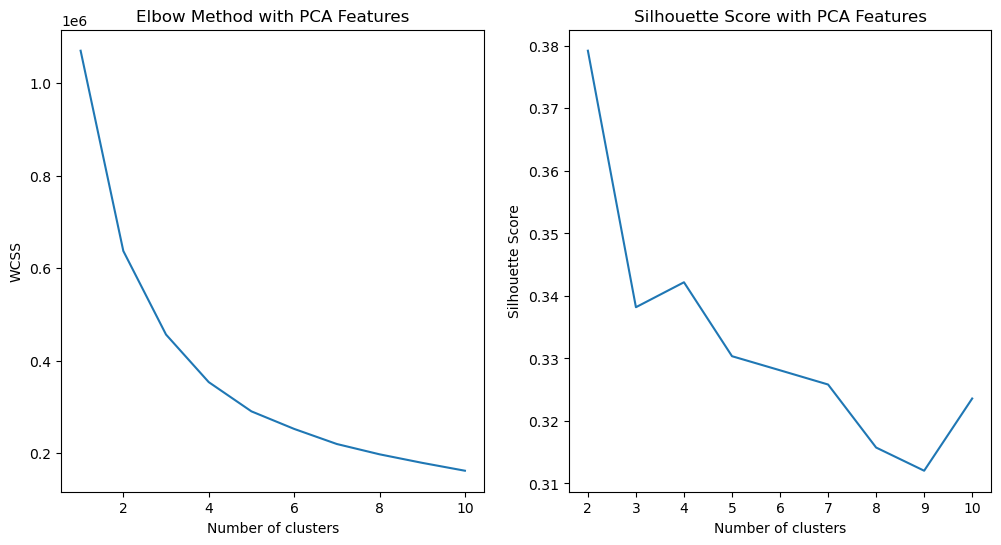

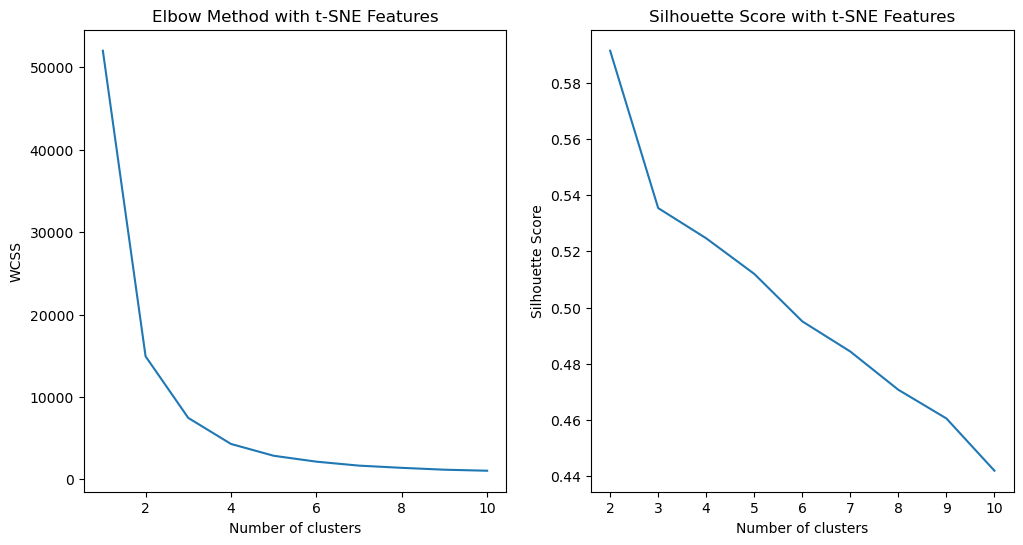

In [ ]:
def evaluate_clustering(features, feature_name):
    #elbow rule
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(features)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 11), wcss)
    plt.title(f'Elbow Method with {feature_name}')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')

    #Contour coefficient rule
    silhouette_scores = []
    for i in range(2, 11):  # Silhouette coefficient requires at least 2 clusters
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(features)
        score = silhouette_score(features, kmeans.labels_)
        silhouette_scores.append(score)

    plt.subplot(1, 2, 2)
    plt.plot(range(2, 11), silhouette_scores)
    plt.title(f'Silhouette Score with {feature_name}')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

# Calculate the elbow rule effects after different operations respectively
evaluate_clustering(features, 'Original Features')
evaluate_clustering(features_scaled, 'Scaled Features')
evaluate_clustering(features_pca, 'PCA Features')
evaluate_clustering(features_tsne, 't-SNE Features')

- Elbow rule plot: shows the relationship between the number of clusters and the within-cluster error sum of squares (WCSS). As the number of clusters increases, the WCSS generally decreases because the samples move closer to their center points. Elbow rule plots typically exhibit a downward bend, and the "elbow" point is where the curve begins to flatten out, i.e., the point where adding more clusters does not significantly reduce WCSS. As can be seen from the figure, when the number of clusters increases from 2 to 3, the decline rate of WCSS slows down, so the possible optimal number of clusters is 2.

- Silhouette coefficient map: represents the silhouette coefficient values ​​under different cluster numbers. The silhouette coefficient measures how similar a sample is to other samples in the same cluster and how different it is from the nearest samples from other clusters. The silhouette coefficient ranges from -1 to 1, with higher values ​​indicating better clustering. In the figure, the silhouette coefficient is highest when the number of clusters is 2, which indicates that two clusters provide the best separation effect on the current data set.

In [22]:
#Select the number of clusters
n_clusters = 2 # the number of clusters as needed

# Use explicit n_init parameter value to perform K-means clustering
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
kmeans.fit(features_tsne)

KMeans(n_clusters=2, n_init=10, random_state=42)

- Analyze the clustering results

Silhouette Score: 0.5912977457046509


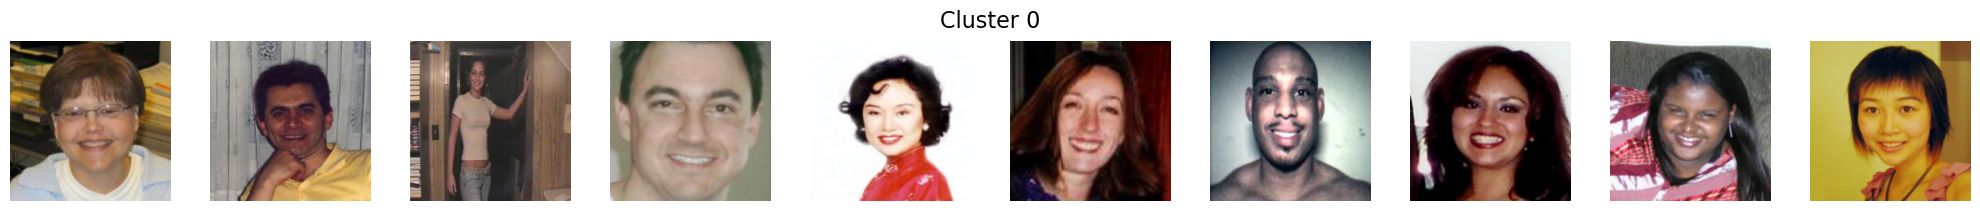

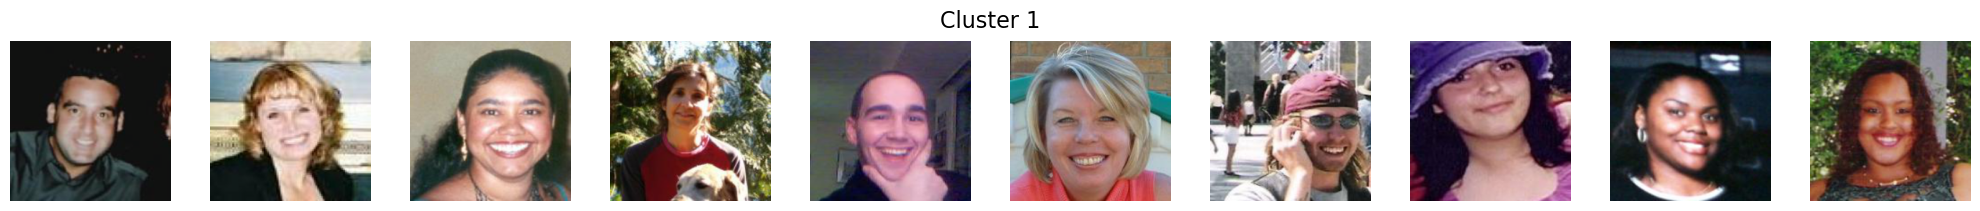

In [ ]:

# Calculate contour coefficient
silhouette_avg = silhouette_score(features_tsne, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')

labels = kmeans.labels_

for cluster in range(n_clusters):
    fig, axes = plt.subplots(1, 10, figsize=(20, 2), constrained_layout=True)
    fig.suptitle(f'Cluster {cluster}', fontsize=16)
    cluster_indices = np.where(labels == cluster)[0]
    for ax, idx in zip(axes, cluster_indices[:10]):
        img = dataset[idx].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.axis('off')
    plt.show()


# 9 Conclusions

We performed image classification and cluster analysis on the Genki4k data set. We used the pre-trained ResNet model to extract features from the images, then used PCA and t-SNE methods to reduce the dimensionality of the feature vectors, and finally used The K-means algorithm was used to cluster the dimensionally reduced feature vectors, and the cluster labels of each picture were obtained. We used the silhouette coefficient to compare and evaluate the clustering results, and found that the clustering effect was very good, and the quality and performance of the clustering were relatively high.

Our work has the following advantages:

- I used the pre-trained ResNet model to extract features from the images, which can use the high-level semantic features that the model has learned to improve the clustering effect, while also saving time and resources for training the model.
- I used PCA and t-SNE methods to reduce the dimensionality of the feature vectors, which can reduce the computational complexity and facilitate visualization and clustering. We also compared the results of PCA and t-SNE and found that t-SNE can better maintain the local similarity of the data and discover complex structures in the data.
- I used the K-means algorithm to cluster the dimensionally reduced feature vectors. This is a simple and effective clustering method that can run quickly on large amounts of data and is easy to implement and understand. We also used the elbow rule and the silhouette coefficient method to select the appropriate number of clusters to achieve the best clustering effect.

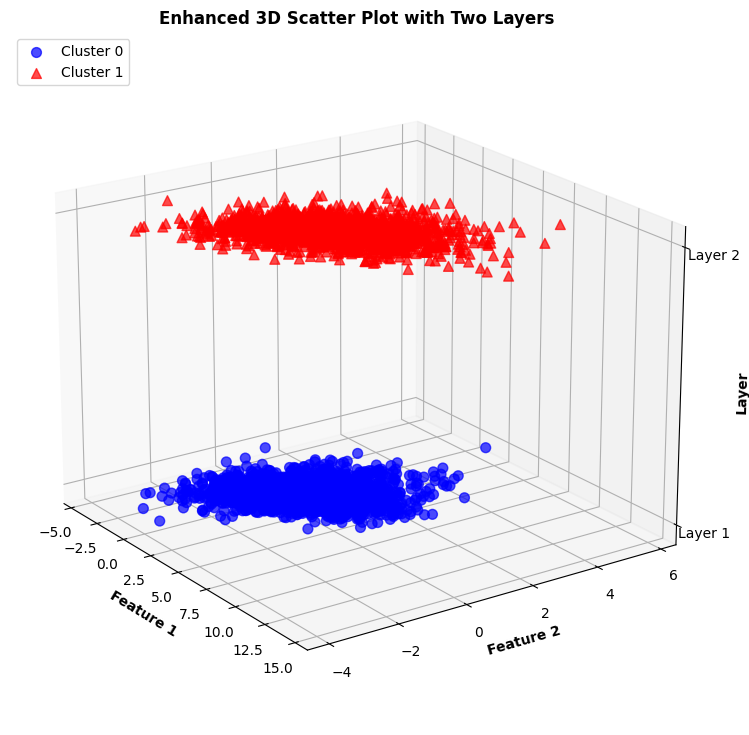

In [24]:
# Assume that features is the sample feature matrix and kmeans.labels_ is the clustering label array
labels = kmeans.labels_

# Select colors and markers
colors = ['b', 'r']
markers = ['o', '^']

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.grid(True)  #Add grid lines

# Draw a scatter plot using two features and stratify by adjusting the value of the z-axis
z_values_layer1 = 1 # level one
z_values_layer2 = 2  # Second floor

# level one
cluster_0_indices = (labels == 0)
ax.scatter(features[cluster_0_indices, 0], features[cluster_0_indices, 1], zs=z_values_layer1, 
           zdir='z', s=50, c=colors[0], depthshade=True, marker=markers[0], alpha=0.7, label='Cluster 0')

# Second floor
cluster_1_indices = (labels == 1)
ax.scatter(features[cluster_1_indices, 0], features[cluster_1_indices, 1], zs=z_values_layer2, 
           zdir='z', s=50, c=colors[1], depthshade=True, marker=markers[1], alpha=0.7, label='Cluster 1')

# Set axis labels
ax.set_xlabel('Feature 1', fontweight='bold')
ax.set_ylabel('Feature 2', fontweight='bold')
ax.set_zlabel('Layer', fontweight='bold')

# Set axis tick labels
ax.set_zticks([z_values_layer1, z_values_layer2])
ax.set_zticklabels(['Layer 1', 'Layer 2'])

plt.title('Enhanced 3D Scatter Plot with Two Layers', fontweight='bold')
plt.legend(loc='upper left')

# Set perspective
ax.view_init(elev=20., azim=-35)

plt.show()